In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

/home/carolyn/anaconda/envs/notebk/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### Backward query exercises from "Make Your Own Neural Net".

In [2]:
import numpy as np
import scipy.special

#neural network class definition 

class NeuralNetwork:
    
    # input number of nodes in each of 3 layers
    def __init__(self, ninodes, nhnodes, nonodes, lr):
        
        self.activation_function = lambda x: scipy.special.expit(x)
        self.inv_activation_function = lambda x: scipy.special.logit(x)
        
        self.inodes = ninodes
        self.hnodes = nhnodes
        self.onodes = nonodes
        self.lr = lr
        
        # initialize matrix with normal random variables 
        self.wih = np.random.normal(0.0, 
                                        pow(float(self.hnodes), -0.5),
                                        (self.hnodes, self.inodes)
                                      )
        self.who = np.random.normal(0.0,
                                     pow(float(self.onodes), -0.5),
                                     (self.onodes, self.hnodes)
                                      )
        
    def rescale_for_logit(self, dataset):
        '''
        dataset: a layerdim L x m data matrix, representing a list of m data 
        points in the L-dimensional space. 
        This function rescales the columns to be in the range [.01,.99]
        So that logit can be applied.
        '''
        # result should be a 1-dim array of length m
        dset_shape = dataset.shape # Lxm
        maxes = np.amax(dataset, axis=0) 
        mins = np.amin(dataset, axis=0)
        
        # debug: asserts are to make sure you got the dimensions right
        m = dset_shape[1]
        assert maxes.shape == (m,)
        
        maxmindiff = maxes - mins
        slopes = .98/maxmindiff
        assert slopes.shape == (m,)
        
        # now this is likely to be a mess.
        # dataset - mins is (l x m) - (m,)
        # I hope it will get broadcast correctly. I think it will, if mins is viewed as just an m-vector.
        # See page: https://docs.scipy.org/doc/numpy-1.10.0/user/basics.broadcasting.html
        transformed = 0.98*slopes*(dataset - mins) + .01
        assert transformed.shape == dset_shape
        return transformed
        
        
    def train(self, inputs_list, targets_list):
        
        # if inputs_list is a list of m items each of length n,
        # np.array will turn it into an mxn matrix.
        # ie, it will add records row by row.
        # the result gets transposed here.
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T
        
        # calculate signals into hidden layer
        hidden_inputs = np.dot(self.wih, inputs)
        
        # calculate signals coming out of hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # calculate signals going into output layer
        final_inputs = np.dot(self.who, hidden_outputs)
        
        # calculate final output
        final_outputs = self.activation_function(final_inputs)
        
        
        # We will need the output and the hidden layer errors,
        # both calculated up front, i.e., before the changes are applied to the interior weights.
        # the hidden layer error is equal to the output_errors 
        # passed backward through the weights between the hidden and output
        # layers (transposed).
        # note that self.wts_ho.T is num_hidden x num_output,
        # so hidden_errors is a num_hidden x 1 vector.
        output_errors = targets - final_outputs
        hidden_errors = np.dot(self.who.T, output_errors)
        
        
        # now we backpropagate.
        # step 1: adjust the hidden->outer weights wts_ho.
        # these are components of the gradient of the error function
        # wrt the hidden->output weights wts_ho (dimension outer x hidden).
        # note that this is an outer product of the 
        # hidden and output components of the gradient        
        self.who += self.lr * np.dot((output_errors*final_outputs*(1.0-final_outputs)), hidden_outputs.T)
        
        # the next step is the same, shifted to the input->hidden weights.
        #hidden_component_of_wts_ih_delta = hidden_errors*hidden_outputs*(1.0-hidden_outputs)
        #input_component_of_wts_ih_delta = inputs
        
        # again, outer product of input and hidden components of the gradient
        self.wih += self.lr * np.dot((hidden_errors*hidden_outputs*(1.0-hidden_outputs)), inputs.T) 
        
        
        pass
    
    def query(self,inputs_list):
        inputs = np.array(inputs_list, ndmin =2).T
        
        # calcualte signals entering hidden layer
        hidden_inputs = np.dot(self.wih, inputs)
        
        # signals leaving hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # signals entering final layer
        final_inputs = np.dot(self.who, hidden_outputs)
        
        # signals leaving final layer
        final_outputs = self.activation_function(final_inputs)
        return final_outputs
    
    def backquery(self, outputs_list):
        '''
        For 'looking into the mind of a neural net'. 
        Give this code a list of m outputs, each of length 10,
        and np.array (with ndmin=2) will turn it into an mx10 array.
        Transposing will make it 10xm. 
        Backquery will generate m corresponding 'inputs'
        which ought to reveal something about what features 
        the net is learning.
        '''
        
        
        outputs = np.array(outputs_list, ndmin=2).T

        # back-transform outputs. All are between 0 and 1 not inclusive, 
        # so all are already in 
        # the right range to apply logit.
        final_inputs = self.inv_activation_function(outputs)
        
        # final_inputs is still 10xm.
        # self.who was a matrix of size 10 x (hnodes).
        # so hidden_outputs will be hnodes x m.
        hidden_outputs = np.dot(self.who.T, final_inputs)
        
        # hidden_outputs values are not guaranteed to be in the range (0,1).
        # now we need to rescale hidden_outputs so we can apply logit.
        # we rescale to [.01,.99].
        rescaled_hidden_outputs = self.rescale_for_logit(hidden_outputs)
        
        #apply logit to the results, which is still hnodes x m.
        hidden_inputs = self.inv_activation_function(rescaled_hidden_outputs)
        
        # next apply the transpose of the set of input weights, 
        # to get a hypothesized set of inputs.
        hypothesized_inputs = np.dot(self.wih.T, hidden_inputs)
        return hypothesized_inputs 
        
        

In [3]:
# access the test and training data.
import os
print(os.getcwd())
os.chdir("/mnt/xferUbuntu/notebooks/make_your_own_neural_network/mnist")
os.listdir(".")


/mnt/xferUbuntu/notebooks/make_your_own_neural_network


['mnist_test.csv',
 'mnist_test_10.csv',
 'mnist_train.csv',
 'mnist_train_100.csv']

In [4]:
training_file = open(os.path.join(os.getcwd(), "mnist_train.csv"), 'r')
training_data = training_file.readlines()
training_file.close()

In [5]:
inodes = 28*28 # number of input nodes = dimensions of input images
hnodes = 100 # he starts by using 100 hidden nodes
onodes = 10 # number of output nodes = 10 (1 per digit)

In [6]:
# set up the TRAINING inputs and target outputs
all_inputs = []
all_targets = []

for line in training_data:
    all_values = line.split(',')
    assert len(all_values) == 28*28+1

    # rescale the input values into the range [0.01, 1.0]
    # you're avoiding the value 0 because the weights can't affect that value,
    # but the value 1 is okay for input.
    # note you do not need to reshape the array before using it for training...
    # the neural net doesn't care whether it looks like an image to you!
    inputs = ((np.asfarray(all_values[1:])/255.0)*0.99) + 0.01
    assert len(inputs) == inodes
    assert inputs.min() >0
    all_inputs.append(inputs)

    # all the non-target entries will be .01, the target entry will be .99
    # otherwise you'll get large weights and a saturated network because you'll be trying 
    # to hit impossible values
    targets = (np.zeros(onodes) + 0.01)
    targets[int(all_values[0])] = 0.99
    all_targets.append(targets)

In [7]:
test_file = open(os.path.join(os.getcwd(), "mnist_test.csv"), 'r')
test_data = test_file.readlines()
test_file.close()

In [8]:
# set up the TEST inputs and target outputs
all_test_inputs = []
all_test_labels = []

for line in test_data:
    all_values = line.split(',')
    assert len(all_values) == 28*28+1

    # rescale the input values into the range [0.01, 1.0]
    # you're avoiding the value 0 because the weights can't affect that value,
    # but the value 1 is okay for input.
    # note you do not need to reshape the array before using it for training...
    # the neural net doesn't care whether it looks like an image to you!
    inputs = ((np.asfarray(all_values[1:])/255.0)*0.99) + 0.01
    assert len(inputs) == inodes
    assert inputs.min() >0
    all_test_inputs.append(inputs)

    label = int(all_values[0])
    all_test_labels.append(label)

In [9]:
lrate = 0.01
nnet3 = NeuralNetwork(inodes, hnodes, onodes, lrate)
accuracies = []

import itertools

for epoch in range(10):
    for inputs, targets in itertools.izip(all_inputs, all_targets):
        # ===>>> now we train individually with every sample.
        nnet3.train(inputs, targets)

    # now tuck the test loop inside the epochs loop, 
    # so you get a test rate per epoch. 
    scorecard = []
    
    # go through test records
    for test_inputs, test_label in itertools.izip(all_test_inputs, all_test_labels):
        
        results = nnet3.query(test_inputs)
        label = np.argmax(results)
        #print "Network says: {}, Target was {}".format(label, test_target_indices[ii])
        if label == test_label:
            scorecard.append(1)
        else:
            scorecard.append(0)

    accuracy = np.mean(scorecard)
    accuracies.append(accuracy)
    print "Accuracy with {} epochs: {}".format(epoch, accuracy)

Accuracy with 0 epochs: 0.9206
Accuracy with 1 epochs: 0.9361
Accuracy with 2 epochs: 0.9462
Accuracy with 3 epochs: 0.9521
Accuracy with 4 epochs: 0.9553
Accuracy with 5 epochs: 0.958
Accuracy with 6 epochs: 0.9592
Accuracy with 7 epochs: 0.9601
Accuracy with 8 epochs: 0.9629
Accuracy with 9 epochs: 0.9638


### Now I have a trained neural net. In the test I just ran, the accuracy got up to 96% after 10 epochs.
### Next I'll run the neural net backward using the backward query code I added. 

The results below are, roughly speaking, the same that Taufiq got. 

Note there is a little matplotlib action there. Removing axes, adding a title to each plot, nothing fancy but I had to look it all up. 

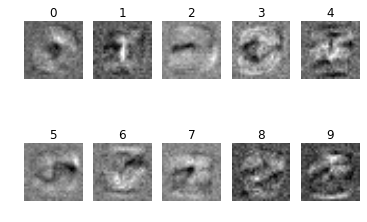

In [18]:
def create_target_for_label(L):
    target = 0.01 * np.ones((10,))
    target[L] = 0.99
    return target

fig = plt.figure()

for ii in range(10):
    subplot_num = (2,5,ii+1)
    fig.add_subplot(*subplot_num)
    target = create_target_for_label(ii)
    response = nnet3.backquery(target)
    plt.imshow(np.reshape(response.flatten(), (28,28)), cmap = 'gray')
    plt.axis('off')
    plt.title('{}'.format(ii))
